<a href="https://colab.research.google.com/github/patimus-prime/ML_notebooks/blob/master/high-throughput-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://i.imgflip.com/6xaidw.jpg" width="300" height="400" />

In [128]:
# mount the google drive, one can alternatively upload manually.
# path is specified below for pandas upload
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import data!

In [129]:
import pandas as pd
import sys as sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# these should also be pre-installed in colab, can use condacolab above otherwise
# used to thoroughly look into linear lines of best fit
import statsmodels.api as sm
import statsmodels.formula.api as smf

# an OPTION for detrending below:
from scipy import signal

In [130]:
# checking the path in drive
!ls

drive  sample_data


In [131]:
# DATA PATH HERE!
df = pd.read_excel("drive/MyDrive/0_ML/Sample_T1_data.xlsx")

In [132]:
df.head()

,counter,plate,strain,well_type,robot,stacker_position,value
0,1,1,X1,Standard Well,Bender,1,10235.737690
1,2,1,X2,Standard Well,Bender,1,10369.993508
2,3,1,X3,Standard Well,Bender,1,9651.469052
3,4,1,X4,Standard Well,Bender,1,10171.884399
4,5,1,X5,Standard Well,Bender,1,9493.364155


In [133]:
df.describe()

,counter,plate,stacker_position,value
count,5760.000000,5760.000000,5760.000000,5760.000000
mean,2880.500000,30.500000,10.500000,8884.673853
std,1662.913107,17.319606,5.766782,729.209775
min,1.000000,1.000000,1.000000,5969.815929
25%,1440.750000,15.750000,5.750000,8384.141743
50%,2880.500000,30.500000,10.500000,8907.513168
75%,4320.250000,45.250000,15.250000,9442.721749
max,5760.000000,60.000000,20.000000,11193.991178


The above .describe returns the data across robots and wells. It's not too useful yet, but I think it and the .head foreshadow some problems I'll be tackling below. There's two initial problems that need to be resolved for later analysis to be more fruitful: 
1. Multiple robots -- ideally we'd like to pool all the X## data to compare their titer, so, we'll need to confirm the results from different robots are comparable. I'll do this by comparing the readouts for the process control (and maybe also the parent strain)
2. Stacker position, or time when the samples are read, definitely affects the control results and so probably affects the X and PS. This will need to be corrected for so we can analyze results independent of time.

Alright, so first, let's see what we actually can compare. We have the process control, so first looking at if the robots' data are similar enough to be compared against each other or if we have to slice by both stack position (time) and robot. This would be... not awesome. Stack position would probably be fine to use but let's create a time feature for clarity.

In [134]:
# TRANSFORM STACK POSITION -> TIME MEASURED
# takes 3 minutes to measure ea. plate, -3 so graph starts at 0
# using 'time_mins' instead of e.g. Time (mins), due to statsmodels freaking out below
df['time_mins'] = df['stacker_position'].apply(lambda x: 3*x-3) 
df.describe()

,counter,plate,stacker_position,value,time_mins
count,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000
mean,2880.500000,30.500000,10.500000,8884.673853,28.500000
std,1662.913107,17.319606,5.766782,729.209775,17.300346
min,1.000000,1.000000,1.000000,5969.815929,0.000000
25%,1440.750000,15.750000,5.750000,8384.141743,14.250000
50%,2880.500000,30.500000,10.500000,8907.513168,28.500000
75%,4320.250000,45.250000,15.250000,9442.721749,42.750000
max,5760.000000,60.000000,20.000000,11193.991178,57.000000


Ok, now let's look at our data. I'm not pooling it together yet, but plotting by robot and well type. 

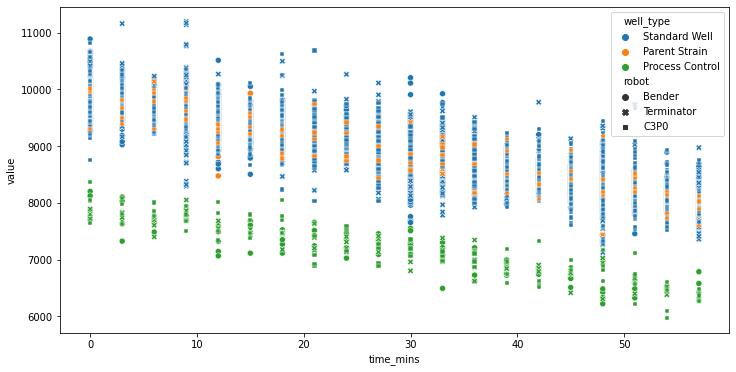

In [135]:
# Plot all, separated by robot and strain type. 
# Let's look at the differences, if maybe we'll detrend then add/subtract means from each

plt.figure(figsize=(12,6))
sns.scatterplot(data = df,                
                # literally x and y axes
                x='time_mins',
                y='value',
                # grouping variables:
                hue = "well_type",
                style = "robot",
                # legend = 'auto', # auto by default
                )

Wow pretty informative for a first graph! Some of the outliers mentioned in the brief are apparent; I'll discuss these in a second. I think the biggest thing to note is the decreasing trend. The process control should hopefully remain constant throughout the experiment, but it's decreasing over time, suggesting the instrument is becoming less sensitive or whatever's being measured is degrading. The same or similar phenomenon is observed for the standard wells and parent strain.

So: we need to confirm the robots are comparable to be able to pool results, and now we also need to correct for this downward trend. The correct order in which to do so is... not immediately apparent, and I'll discuss below why I chose the route I did, but let's first look at another representation that may be a little more clean: 

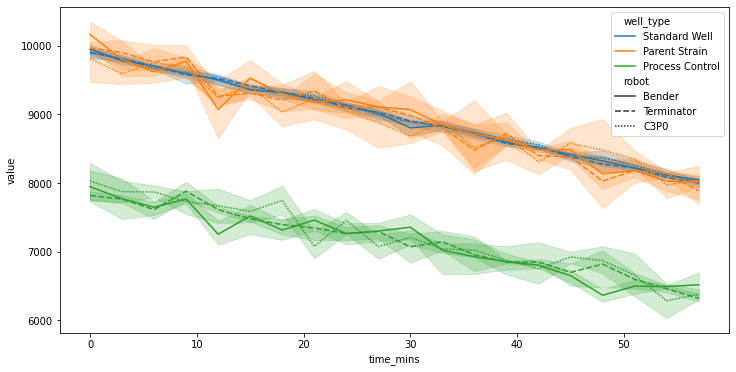

In [136]:
# FIXME MORE DESCRIPTIVE OF LINE PLOT ETC. MAYBE LOOK UP YOUTUBE
# also a line plot, which also helps to visualize a bit:
# https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot
# "By default, the plot aggregates over multiple y values at each value of x and shows an estimate of the central tendency and a confidence interval for that estimate."

plt.figure(figsize=(12,6))
sns.lineplot(data = df,                
                # literally x and y axes
                x='time_mins',
                y='value',
                # grouping variables:
                hue = "well_type",
                style = "robot",
                # legend = 'auto', # auto by default
                )

Still not an exhaustive analysis, but it appears in this plot the robots may have differences that may need to be accounted for or at least acknowledged. What mostly sticks out to me is that at time 12, we see a drop in both the process control and parent strain for Bender. 

But, for the most part...

# That looks good!

Ok, so, we see now that there's a fairly linear downward trend; we can remove that and correct for whatever's happening, molecule getting eaten or instrument inefficiency. And, at least visually, it seems the robots are... fairly comparable. But, just saying that isn't enough... we need to do some statistical analysis.

---


So, with the goal of pooling all our results and having more samples to compare against and increasing our decision-making power, we need to correct for the downward trend over time, and confirm we can pool the robots; or at least account for the error we'll introduce by making these assumptions.

Some initial problems:
- There are a few methods to correct for the downward trend, and I think the most... transparent is to employ a line of best fit and subtract it from each sample. This will then give us the differences from the line of best fit as the value for each sample; a +/- from some predicted value. This line will be affected by outliers. Do we remove them now or when we can more effectively compare outliers against more data? For now I'm going with the latter; I think reproducing the analysis below with the outliers removed may then be of interest to see how much effect they were having.
- Detrend each robot separately, or with the same line of best fit for each well type, thereby assuming we can move forward with the assumption the robots are comparable?

Ultimately, the goal is to compare all X at all times to choose which to move forward with in subsequent screening. So, I'll reiterate below, but I think moving forward with the assumption the robots are comparable, pooling data as much as possible, then removing outliers and confirming our assumption of comparability, will be the most fruitful. 

So:
- Assume robot results comparable, can pool results from each for the different well types
- Fit line of best fit, used to detrend, per well type. This... also needs to be discussed!

---

We'll check the math below also, but the line of best fit will be fit per well type. It all seems so clear from here...

<img src="https://i.pinimg.com/originals/b5/04/cc/b504cc8d7ec95babd00557d8bd72aa00.jpg" width="300" height="400" />

The plot below is produced by seaborn, which does not feature exposable statistics, so the lines aren't necessarily the same as what'll be calculated with the statmodels package. But, we do get to see that the lines of best fit are fairly parallel and there's a similar linear trend down.

<Figure size 864x432 with 0 Axes>

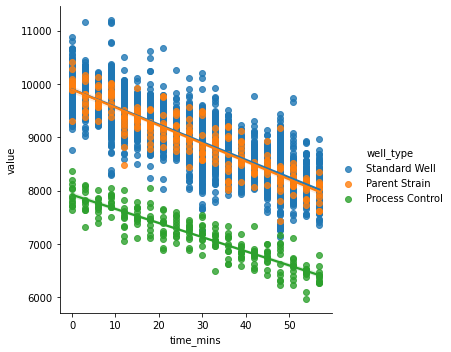

In [138]:
# Seaborn is limited to providing visualization,
# it is not possible to extract regression coefficients from graphs lol
plt.figure(figsize=(12,6))
sns.lmplot(data = df,                
                # literally x and y axes
                x='time_mins',
                y='value',
                # grouping variables:
                hue = "well_type",
                )

Appear fairly parallel, let's quantify though. The detrending method I'm going with is to subtract the line of best fit. There are alternatives like subtracting a rolling mean, but I think the math and transformation of the data is more opaque using that method. Plus the trend does really look linear.

I'd like to see how similar these lines come out to be, so we're ideally removing the same trend that appears in the control from PS and X, thereby removing whatever underlying effect is occurring in the control and not some trend that's a real signal from X/PS. 

Reiterating!! The lines of best fit below are made using statmodels, ordinary least squares method, not necessarily equivalent to the seaborn method of drawing the lines above.


In [139]:
# let's see first how the lines fit to PS, PC, and X are. if slope is the same...
# not really anything to adjust
# we'll go one by one, see how well this is really fitting to the data...

# PC:

pc_data = df[df.well_type == 'Process Control']
# pc_data.describe()

pc_ols = smf.ols('value ~ time_mins', data=pc_data).fit()
print("SUMMARY FOR PC")
print(pc_ols.summary())

SUMMARY FOR PC
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     1113.
Date:                Wed, 19 Oct 2022   Prob (F-statistic):           1.07e-91
Time:                        08:50:50   Log-Likelihood:                -1625.7
No. Observations:                 240   AIC:                             3255.
Df Residuals:                     238   BIC:                             3262.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7922.4692     26.432    2

Approx m = -26; b = 7900; doubt b matters but let's see if m is approx the same in others. R^2 is... not great, not terrible

In [140]:
ps_data = df[df.well_type == 'Parent Strain']

ps_ols = smf.ols('value ~ time_mins', data=ps_data).fit()
print("SUMMARY FOR PS")
print(ps_ols.summary())

SUMMARY FOR PS
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     1090.
Date:                Wed, 19 Oct 2022   Prob (F-statistic):           8.30e-91
Time:                        08:50:51   Log-Likelihood:                -1686.0
No. Observations:                 240   AIC:                             3376.
Df Residuals:                     238   BIC:                             3383.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9897.3872     33.990    2

In [141]:
x_data = df[df.well_type == 'Standard Well']

x_ols = smf.ols('value ~ time_mins', data=x_data).fit()
print("SUMMARY FOR X")
print(x_ols.summary())

SUMMARY FOR X
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                 2.054e+04
Date:                Wed, 19 Oct 2022   Prob (F-statistic):               0.00
Time:                        08:50:51   Log-Likelihood:                -37420.
No. Observations:                5280   AIC:                         7.484e+04
Df Residuals:                    5278   BIC:                         7.486e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9901.1477      7.680   128

In [142]:
pc_data['predicted_value'] = pc_ols.predict(pc_data.time_mins)
pc_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,counter,plate,strain,well_type,robot,stacker_position,value,time_mins,predicted_value
92,93,1,Y0001,Process Control,Bender,1,8201.149131,0,7922.469212
93,94,1,Y0001,Process Control,Bender,1,7703.484788,0,7922.469212
94,95,1,Y0001,Process Control,Bender,1,7761.724704,0,7922.469212
95,96,1,Y0001,Process Control,Bender,1,8122.782322,0,7922.469212
188,189,2,Y0001,Process Control,Bender,2,8102.489627,3,7843.127112


In [143]:
# ONE line solution, axis=1 informs pandas to look for a column when referencing x
pc_data['detrended_value'] = pc_data.apply(lambda x: x['value'] - x['predicted_value'], axis = 1)

pc_data.head()

# OK!!! finally

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,counter,plate,strain,well_type,robot,stacker_position,value,time_mins,predicted_value,detrended_value
92,93,1,Y0001,Process Control,Bender,1,8201.149131,0,7922.469212,278.679919
93,94,1,Y0001,Process Control,Bender,1,7703.484788,0,7922.469212,-218.984424
94,95,1,Y0001,Process Control,Bender,1,7761.724704,0,7922.469212,-160.744508
95,96,1,Y0001,Process Control,Bender,1,8122.782322,0,7922.469212,200.313110
188,189,2,Y0001,Process Control,Bender,2,8102.489627,3,7843.127112,259.362514


In [144]:
# same thing for the other dataframes. hope the math is clear atm!
# PS:
ps_data['predicted_value'] = ps_ols.predict(ps_data.time_mins)
ps_data['detrended_value'] = ps_data.apply(lambda x: x['value'] - x['predicted_value'], axis = 1)
# X:
x_data['predicted_value'] = x_ols.predict(x_data.time_mins)
x_data['detrended_value'] = x_data.apply(lambda x: x['value'] - x['predicted_value'], axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [145]:
x_data.describe() # IT WORKED!

,counter,plate,stacker_position,value,time_mins,predicted_value,detrended_value
count,5280.000000,5280.000000,5280.000000,5280.000000,5280.000000,5280.000000,5.280000e+03
mean,2876.500000,30.500000,10.500000,8960.237927,28.500000,8960.237927,3.019075e-12
std,1662.889342,17.319742,5.766827,640.361179,17.300482,571.164657,2.895399e+02
min,1.000000,1.000000,1.000000,7125.219488,0.000000,8019.328162,-1.651311e+03
25%,1438.750000,15.750000,5.750000,8456.581356,14.250000,8489.783044,-1.593694e+02
50%,2876.500000,30.500000,10.500000,8952.667777,28.500000,8960.237927,-7.125661e+00
75%,4314.250000,45.250000,15.250000,9462.720736,42.750000,9430.692810,1.567165e+02
max,5752.000000,60.000000,20.000000,11193.991178,57.000000,9901.147692,1.589973e+03


In [146]:
# Now let's bring the band back together and visualize again. THEN, FINALLY...
# we'll have a detrended dataset and can do some proper analysis

# d for detrended
d_df = pc_data
d_df = d_df.append(ps_data)
d_df = d_df.append(x_data)


In [147]:
d_df.describe()

,counter,plate,stacker_position,value,time_mins,predicted_value,detrended_value
count,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5.760000e+03
mean,2880.500000,30.500000,10.500000,8884.673853,28.500000,8884.673853,2.719958e-12
std,1662.913107,17.319606,5.766782,729.209775,17.300346,670.783243,2.860013e+02
min,1.000000,1.000000,1.000000,5969.815929,0.000000,6414.969312,-1.651311e+03
25%,1440.750000,15.750000,5.750000,8384.141743,14.250000,8415.500694,-1.577005e+02
50%,2880.500000,30.500000,10.500000,8907.513168,28.500000,8910.716360,-5.998895e+00
75%,4320.250000,45.250000,15.250000,9442.721749,42.750000,9405.932026,1.556465e+02
max,5760.000000,60.000000,20.000000,11193.991178,57.000000,9901.147692,1.589973e+03


YES! Back to 5760 counter, mean for detrended value is effectively 0

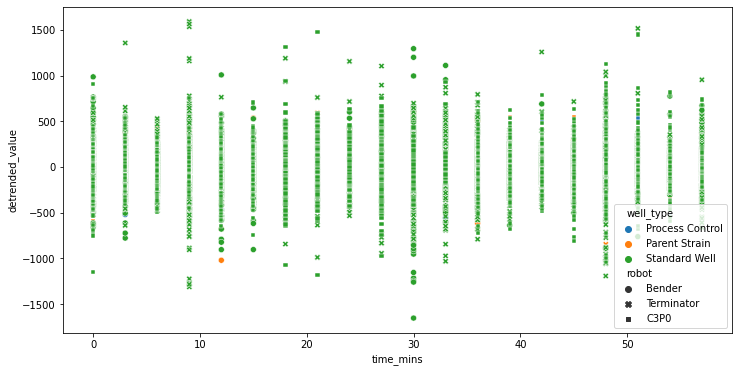

In [148]:
plt.figure(figsize=(12,6))
sns.scatterplot(data = d_df,                
                # literally x and y axes
                x='time_mins',
                y='detrended_value',
                # grouping variables:
                hue = "well_type",
                style = "robot",
                # legend = 'auto', # auto by default
                )

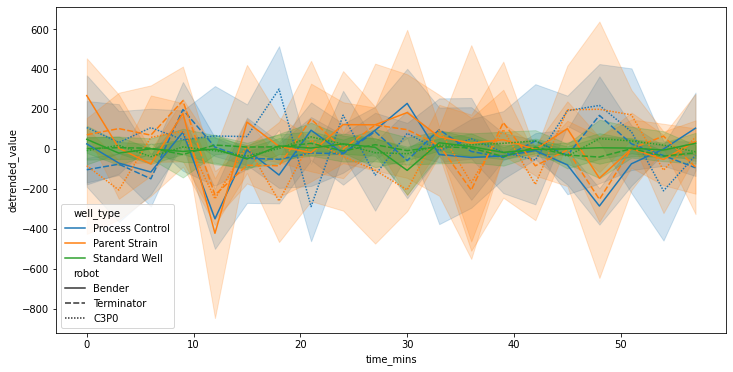

In [149]:
plt.figure(figsize=(12,6))
sns.lineplot(data = d_df,                
                # literally x and y axes
                x='time_mins',
                y='detrended_value',
                # grouping variables:
                hue = "well_type",
                style = "robot",
                # legend = 'auto', # auto by default
                )

Alright, looks like it worked!!!! :)))))

We now have completed that first step 1, detrending the data. Whew. 

Now, again seaborn isn't a substitute for later analysis, but global mean is about 0. And looking at the confidence intervals that seaborn drew, there is not a uniform spread of the data for the different well types.

This is of interest, because the next steps involve the mean and comparing distributions, at least as I'm analyzing this. Those next steps are:

1. Confirm that robot results are comparable by examining the process controls, or see extent of difference in distributions. The mean now artifically is at 0, but we can properly compare the distributions of the process control from different robots and see how large the standard deviation is. Anyway, this is ANOVA between different process control results from the different robots.

2. Compare the X and PS populations; a t-test. Take the top n% p < 0.05 or w/e from X versus PS.

3. Also clean stuff up, remove outliers beyond 3 stdev, following the rule from 1. Add those outliers to a dataframe; identify the highly positive ones as of interest, could be not a fluke. 

4. This whole thing is getting a little lengthy, but in future work, could re-do the line fitting and see the extent of the difference.  

---
---
---

<img src="https://i.kym-cdn.com/photos/images/original/001/930/800/8ce.jpg" width="400" height="400" />

# Analysis of Variance in Process Controls

So, this is one strategy we could of used to do the ANOVA for the extent of deviation in the process control. An alternative would of been to regard the process control with a repeated measure ANOVA, which we could still do, and see how the variation changed over time... could still do! But now effectively we've made our results independent of time and can compare. 

In [150]:
# alright, going in with the goal of just getting the stdev of ea. distribution,
# comparing that since all the means will definitely be the same.

# looking into it I like the scipy implementation better in this case;
# documentation for scipy and statsmodels:
# https://www.statsmodels.org/dev/anova.html
# https://www.statsmodels.org/dev/generated/statsmodels.stats.anova.anova_lm.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html
# https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.stats.f_oneway.html

BUT WAIT! ANOVA assumes homoscedasticity. We literally have to assume that the stdev of all groups are the same. And we've now forced the means to all be the same; and otherwise we have to really do the repeated measure ANOVA BEFORE the detrending, which... isn't ideal and I'm not sure if necessarily informative if we're going to have to detrend the data anyway.

Uhhh... let's do ANOVA anyway to be thorough and provide evidence for the assumption of comparability of robot results and see if anything goes wrong.

In [151]:
# get a dataframe with just the process control data
d_pc_df = d_df[d_df.well_type == 'Process Control']

# look at stdev for bender robot, then the others
d_pc_df[d_pc_df.robot == 'Bender'].detrended_value.std()

218.27036273591693

In [152]:
d_pc_df[d_pc_df.robot == 'C3P0'].detrended_value.std()

241.86697853343276

In [153]:
d_pc_df[d_pc_df.robot == 'Terminator'].detrended_value.std()

165.36536877267446

Similar enough numbers, we'll look at visualizations below, but homoscedasticity seems to hold true. For removing outliers... I think now we can go forward treating process control and other data altogether from the different robots. So remove outliers and conduct analysis based on the whole of the data.

In [154]:
d_pc_df.detrended_value.std()


212.02497297359454

Overall stdev of 212, so outliers fall outside of 3*212; therefore any values greater than -630 or +630 can be considered outliers...

In [155]:
d_pc_df[d_pc_df.well_type == 'Process Control'].describe()

,counter,plate,stacker_position,value,time_mins,predicted_value,detrended_value
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,2.400000e+02
mean,2926.500000,30.500000,10.500000,7168.719262,28.500000,7168.719262,2.808065e-12
std,1666.012678,17.354295,5.778332,505.118546,17.334996,458.465000,2.120250e+02
min,93.000000,1.000000,1.000000,5969.815929,0.000000,6414.969312,-5.566123e+02
25%,1509.750000,15.750000,5.750000,6784.351269,14.250000,6791.844287,-1.262062e+02
50%,2926.500000,30.500000,10.500000,7173.294809,28.500000,7168.719262,5.696354e+00
75%,4343.250000,45.250000,15.250000,7563.393400,42.750000,7545.594237,1.357696e+02
max,5760.000000,60.000000,20.000000,8373.677376,57.000000,7922.469212,6.017727e+02


No, we don't see outliers in the control's detrended values. Woop! Min -556, max 601, both less than the 630 cutoff. Ok. So... We can consider the process control's stdev/outlier cutoff as some analagous measure of the instrument error for all data; this just informs the floor for outliers, likely will be greater stdev for the parent and candidate strains.


Anyway, we got homoscedasticity (yes, I'm having to copy and paste this word), let's go ahead and confirm if the null hypothesis for the process control from different robots using ANOVA...

In [156]:
# ANOVA!!

from scipy.stats import f_oneway
# the scipy implementation takes in a 1D vector of values... soooo... let's see how to get that out
# d_df[d_df.robot == 'Terminator'].detrended_value.values # this should work i guess

f_oneway(d_pc_df[d_pc_df.robot == 'Terminator'].detrended_value.values,
         d_pc_df[d_pc_df.robot == 'Bender'].detrended_value.values,
         d_pc_df[d_pc_df.robot == 'C3P0'].detrended_value.values)

F_onewayResult(statistic=2.2322435342736218, pvalue=0.10953852603139198)

Without even calculating F-critical, we see that the p-value is well above 0.05, and thus the null hypothesis shouldn't be rejected. It is surprising it isn't much larger though! Basically squeaking by assuming that the controls are equivalent.

If I have some time maybe I'll come back and look into the F-critical but otherwise, yeah, go forward with the assumption the process controls are equivalent.

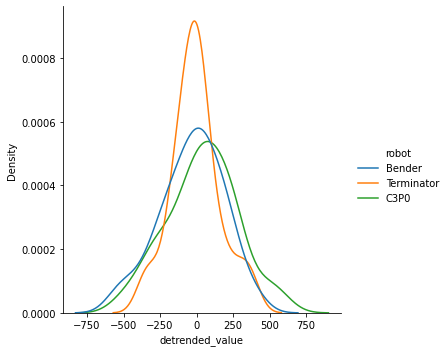

In [157]:
###############
# Let's look at this visually instead of just a line of readout from anova:
#############
sns.displot(data = d_df[d_df.well_type == 'Process Control'],
            x = "detrended_value",
            hue = 'robot',
            kind = 'kde'
)

Seems like Terminator is the most consistent... unlike the movies... Anyway, despite the difference in stdev, seem fairly similar; aritfically at mean = 0, so that's not valuable. We'll better be able to assess how this informs results when we look at PS/X below.

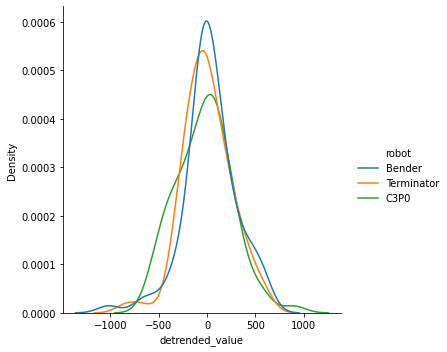

In [158]:
sns.displot(data = d_df[d_df.well_type == 'Parent Strain'],
            x = "detrended_value",
            hue = 'robot',
            kind = 'kde'
)

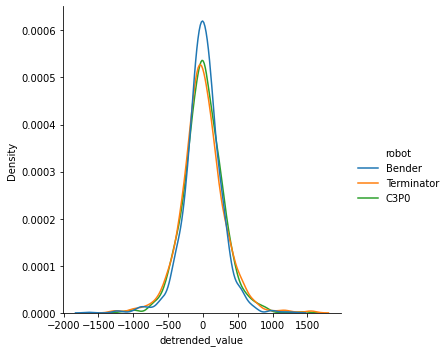

In [159]:
sns.displot(data = d_df[d_df.well_type == 'Standard Well'],
            x = "detrended_value",
            hue = 'robot',
            kind = 'kde'
)

Yeah, way more data spread! I'll also put all these up again in a sec to compare each other. But, parent strain serves somewhat as a second control, and we see the candidate strains very much have greater spread. Many extreme values could be outliers, and I'll filter those out in a sec, but, anyway we'll keep track of the positive ones as potential super-duper candidates.

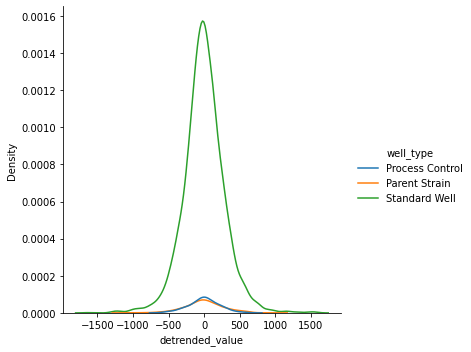

In [160]:
sns.displot(data = d_df,#[d_df.well_type == 'Standard Well'],
            x = "detrended_value",
            hue = 'well_type',
            kind = 'kde'
)

Can definitely better see the spread here, and that there definitely will be some standard well samples that measure well above 2 or 3 stdev of the parent strain.

---





# Outlier Removal

Now we come to the penultimate step: remove outliers from X and PS, (add the really postiive X outliers to some suspicious but of-interest dataframe) and then make suggestions of which candidate strains to move forward into a subsequent round of screening.

In [161]:
# MAY IGNORE THIS CELL, KEPT HERE FOR ANTIQUITY. THERE'S A MORE
# ELEGANT SOLUTION I CAME ACROSS, ACCREDITED AND IMPLEMENTED BELOW. 

# define cutoff for outliers... i'll dump the negative, but keep the positive
# at least for X. So for PS we'll compare absolute, but X will require
# an extra statement

# # mean is ~0 so no need to subtract from mean
# ps_outlier_cutoff = 3*(d_df[d_df.well_type == 'Parent Strain'].detrended_value.std())
# X_outlier_cutoff_neg = -3*(d_df[d_df.well_type == 'Standard Well'].detrended_value.std())
# X_outlier_cutoff_pos = 3*(d_df[d_df.well_type == 'Standard Well'].detrended_value.std())

# just to confirm values we're using:
# print('ps_cutoff: ',ps_outlier_cutoff)
# print('x_neg: ',X_outlier_cutoff_neg)
# print('x_pos: ',X_outlier_cutoff_pos)

In [162]:
# or use this elegant z-score solution I liked while checking if pandas had a built-in method:
# the tanemaki/Rabinzel solution
# https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe
from scipy import stats

# get just the parent strain data
ps_detrended = d_df[d_df.well_type == 'Parent Strain']

# find outliers in the data; outside zscore of 3, 3 stdev; note gets absolute value so anything +/-
ps_outliers = ps_detrended[(np.abs(stats.zscore(ps_detrended.detrended_value)) > 3)]

# redefine data to NOT have those outliers
ps_detrended = ps_detrended[(np.abs(stats.zscore(ps_detrended.detrended_value)) < 3)]

# show outliers found and removed, just 3 of em lol
ps_outliers

,counter,plate,strain,well_type,robot,stacker_position,value,time_mins,predicted_value,detrended_value
472,473,5,Y0002,Parent Strain,Bender,5,8474.186405,12,9493.526840,-1019.340435
3547,3548,37,Y0002,Parent Strain,Terminator,17,7436.487529,48,8281.945699,-845.458170
5464,5465,57,Y0002,Parent Strain,C3P0,17,9179.195553,48,8281.945699,897.249854


Now do for the candidate strains, X. Won't use absolute, wanna keep track of the positive outliers. After this we'll find the statistically significant X (vs. PS).

In [163]:
# get just the CANDIDATE strain data
X_detrended = d_df[d_df.well_type == 'Standard Well']

# find outliers in the data;
# THIS LINE and next get the negative and positive ID'd
# outside zscore of 3, 3 stdev; note gets absolute value so anything +/-
X_outliers_negative = X_detrended[(stats.zscore(X_detrended.detrended_value)) < -3]
print("Amount of negative outliers: ", len(X_outliers_negative))

X_outliers_positive = X_detrended[(stats.zscore(X_detrended.detrended_value)) >= 3]
print("Amount of positive outliers: ", len(X_outliers_positive))

# and finally, get the cleaned up X data, stuff within 3 stdev/z-score of 3
X_detrended = X_detrended[(np.abs(stats.zscore(X_detrended.detrended_value)) < 3)]
print("Remaining non-outlier samples: ", len(X_detrended))

# X_outliers_negative # pollutes the output below, can uncomment if you want
# X_outliers_positive # also pollutes, but look at it later cuz while outliers could be very good candidates!

Amount of negative outliers:  38
Amount of positive outliers:  34
Remaining non-outlier samples:  5208


# FINALLY, finding the most excellent candidate strains!

I thought about doing a t-test here... but really it seems like overkill. We want stuff that is definitely significantly superior to the Parent Strain. So... let's find samples that are greater than 99% of the parent strains. So far it leaves about 100 candidates, not including the positive outliers above.

In [164]:
final_cutoff = ps_detrended.detrended_value.quantile(0.99) # this is the 99% cutoff

# get the candidates that have a value above this cutoff
super_candidates = X_detrended[(X_detrended.detrended_value > final_cutoff)]
print("Number of excellent candidates: ", len(super_candidates))
print("Also: YEEEEEEESSSSSSSSSSSSSSSSSS!!!!!!!!!!!!!!!")

Number of excellent candidates:  99
Also: YEEEEEEESSSSSSSSSSSSSSSSSS!!!!!!!!!!!!!!!


<img src="https://y.yarn.co/652a8aa6-b8fc-4d0c-88c8-74c1ed237e96_text.gif" width="400" height="300" />

WOOP WOOP! We have now identified the candidates that are likely of greatest interest. I'll examine them and report a a couple nice 1-D vectors to verify below, but let's quickly summarize first! 

---

Very briefly: We detrended the data to be able to compare all the candidates that were measured, verified they were comparable by examining variation in the process controls, removed outliers, found a cutoff based on the parent strain, and identified 99 samples that were above this cutoff (and also not outliers in their own distribution). 

Ok! Now let's look at these delicious results. I'll plot them, and include the outliers that could be real results.

In [165]:
# super_candidates and X_outliers_positive are our results, I'll 
# put them together to plot so we can see 'em
# i don't know if I'll also include the PS, I'm... tired lol

super_candidates['sus'] = False
X_outliers_positive['sus'] = True
# super_candidates.head()
all_candidates = super_candidates.append(X_outliers_positive)
# all_candidates.head()
# all_candidates.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<Figure size 864x432 with 0 Axes>

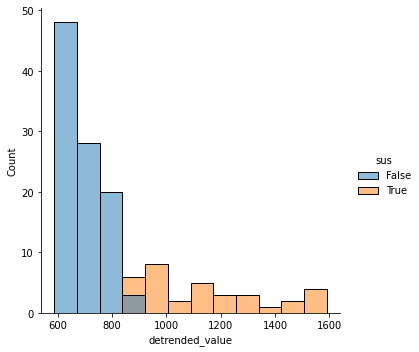

In [166]:
plt.figure(figsize=(12,6))
sns.displot(data = all_candidates,
            x = "detrended_value",
            hue = 'sus',
            # kind = 'kde'
)

In [167]:
all_candidates.detrended_value.describe()

count     133.000000
mean      802.853796
std       235.189934
min       588.575985
25%       645.124123
50%       715.672590
75%       871.872999
max      1589.972886
Name: detrended_value, dtype: float64

In [168]:
print("also, the min of the outliers: ", X_outliers_positive.detrended_value.min())

also, the min of the outliers:  871.8729986745548


Alrighty then! So we see that the strains of interest start above around 600 greater than the mean of the parent strain*, and basically become less numerous. The max is about 1600 above that mean, but may be an outlier.

*Mathematically, greater than the mean of the candidate strains, but the detrending renders this at 0 for both the candidate strains and parent strain, for better or worse given the line of best fit predicted for either dataset.

There's 133 candidates we have here. I'll... leave it as is, one could slice this different ways depending on inclusion of the potential outliers or not. But I'll output a 1D vector of these 3 dataframes below.

I guess, most surprising to me is how even for these approx. 100/5280 candidates, one only sees maybe... 800 on average improvement, which I guess is the absorbance of the molecule, so maybe reflects 8-10% improvement over the original parent strain. Let's do some math below just to be thorough.

In [169]:
f = df[df.well_type == 'Parent Strain']
print("original mean of parent strain, before detrending: ",f.value.mean())
print('mean of our results including outliers, representing a delta over the parent strain: ', all_candidates.detrended_value.mean())
print('percent improvement in these samples, including outliers: ',
      all_candidates.detrended_value.mean()/f.value.mean())
print('percent improvement without outliers: ',
      super_candidates.detrended_value.mean()/f.value.mean())

original mean of parent strain, before detrending:  8938.21881694989
mean of our results including outliers, representing a delta over the parent strain:  802.8537962458497
percent improvement in these samples, including outliers:  0.08982257121780987
percent improvement without outliers:  0.07696986769771348


So, these numbers suggest somewhere around 7-9% improvement in these strains; in 99 or 133/5280 strains. Neat!

In [170]:
all_candidate_strains_counter = all_candidates.counter.values

# super candidates, doesn't include outliers
super_candidate_strains_counter = super_candidates.counter.values
# potential outlier candidates
outlier_counters = X_outliers_positive.counter.values

print('sample output: ')
outlier_counters

sample output: 


array([  66,  390,  974,  992, 1016, 1095, 1118, 2067, 2212, 2219, 2220,
       2251, 2290, 2524, 2545, 2703, 2844, 2854, 2985, 3301, 3521, 3544,
       3636, 3794, 3850, 4447, 4453, 4549, 4924, 5414, 5431, 5433, 5443,
       5508])

# AND THAT'S IT!!!!!

WE HAVE DONE IT!! IDENTIFIED 133 CANDIDATES BASED ON CUTOFFS DESCRIBED ABOVE AND HOPEFULLY THOROUGH AND VALID MATH, OR AT LEAST... *some* MATH THAT IS THOROUGHLY DOCUMENTED.

YES!!!!! And... I guess that's it! Thanks for reading through all this, and thanks for your time and consideration!

-Pat

https://www.youtube.com/watch?v=R-h1dee2S94